## Background

---

In this first notebook, we are going to focus on the exploration and manipulation of our data, whereas the next one would be centered around modeling itself. Understanding the data is important for analytics, and we recommend that you read this notebook before diving into modeling in order to gain a better grasp of our big and messy datasets. The datasets that we are using consist of sales records for a retailer with 45 stores, each containing several departments. They are already included in the repository where this Jupyter notebook is located (see the "Data" folder), but you can also find them on [this Kaggle page](https://www.kaggle.com/manjeetsingh/retaildataset?select=sales+data-set.csv). 

Let's first go ahead and import the libraries we need and load our data:

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# ipywidgets are used to make interactive contents in Jupyter notebooks
from ipywidgets import interact

df_sales = pd.read_csv('Data/sales.csv')
df_features = pd.read_csv('Data/features.csv')
df_stores = pd.read_csv('Data/stores.csv')

# converting the date column (initally stored as strings) to dates
df_sales['Date'] = pd.to_datetime(df_sales['Date'], format='%d/%m/%Y')
df_features['Date'] = pd.to_datetime(df_features['Date'], format='%d/%m/%Y')

df_sales['Store'] = df_sales['Store'].astype('category')
df_sales['Dept'] = df_sales['Dept'].astype('category')
df_features['Store'] = df_features['Store'].astype('category')
df_stores['Store'] = df_stores['Store'].astype('category')
df_stores['Type'] = df_stores['Type'].astype('category')

# Information on the SettingWithCopywarning that might occur: 
# https://www.dataquest.io/blog/settingwithcopywarning/

## Exploratory Data Analysis

---

Before we build a model, it is always a good idea to take a look at the data itself. Here are some questions that you might ask when exploring your data:

- What information is recorded (what do different columns contain)?
- How frequently (since we are working with time series data) is the data recorded?
- How many missing values are there in each column? 
- What are the distributions of the different columns? 
- Are there any columns which are highly correlated with one another?

After exploration, if there are lots of missing values or if the distribution of a column is highly left/right skewed, which could potentially affect the accruacy of your models, you would want to think about replacing or transforming them before you build, compare, and select your models. Since we have a big dataset containing multiple stores and departments, we can create an interactive (and basic) widget using `ipywidgets` for a preliminary inspection of the sales record at each store and department (please read its [documentation](https://ipywidgets.readthedocs.io/en/latest/) for more information or tutorials):

In [3]:
def sales_viz(store_num, dept_num):
    fig, axes = plt.subplots(1,2, figsize=(10,3), dpi=100)
    # Subset the data based on store and department numbers
    sales_temp = df_sales[(df_sales.Store==store_num) & (df_sales.Dept==dept_num)][['Date', 'Weekly_Sales']]
    # Create time series dataframe by using date as index
    ts_sales_temp = sales_temp.set_index('Date')
    ts_sales_temp.plot(ax=axes[0], legend=False)
    ts_sales_temp.hist(ax=axes[1], bins=100)
    display(ts_sales_temp.describe().transpose().round(2))
    plt.show()
    return

display(interact(sales_viz, store_num={n:n for n in range(1,46)}, dept_num={n:n for n in range(1,100)}))

interactive(children=(Dropdown(description='store_num', options={1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: …

<function __main__.sales_viz(store_num, dept_num)>

### Inspection

#### `Sales`

Now we can take a look at the `sales` dataframe, which has 5 fields (columns) and 421,570 observations (rows). Note that we had mannually changed the data types in the 'Store', 'Dept', and 'Date' columns when we imported the data

In [5]:
print(df_sales.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  category      
 1   Dept          421570 non-null  category      
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
dtypes: bool(1), category(2), datetime64[ns](1), float64(1)
memory usage: 7.6 MB
None


,count,mean,std,min,25%,50%,75%,max
Weekly_Sales,421570.0,15981.26,22711.18,-4988.94,2079.65,7612.03,20205.85,693099.36


CAUTION: 0.30% of the `Weekly_Sales` column is negative.


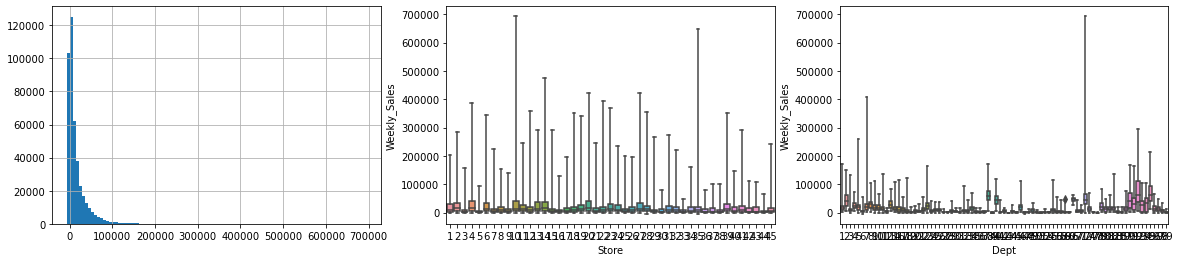

In [7]:
display(df_sales.describe().transpose().round(2))

print("CAUTION: {:.2%} of the `Weekly_Sales` column is negative."
      .format(len([n for n in df_sales['Weekly_Sales'] if n < 0])/
              len(df_sales['Weekly_Sales'])))

fig, axes = plt.subplots(1,3, figsize=(20,4))

df_sales['Weekly_Sales'].hist(bins=100, ax=axes[0])
sns.boxplot(x='Store', y='Weekly_Sales', whis=100, data=df_sales, ax=axes[1])
sns.boxplot(x='Dept', y='Weekly_Sales', whis=100, data=df_sales, ax=axes[2])

plt.show()

,count,unique,top,freq,first,last
Store,421570,45,13,10474,NaT,NaT
Dept,421570,81,1,6435,NaT,NaT
Date,421570,143,2011-12-23 00:00:00,3027,2010-02-05,2012-10-26
IsHoliday,421570,2,False,391909,NaT,NaT


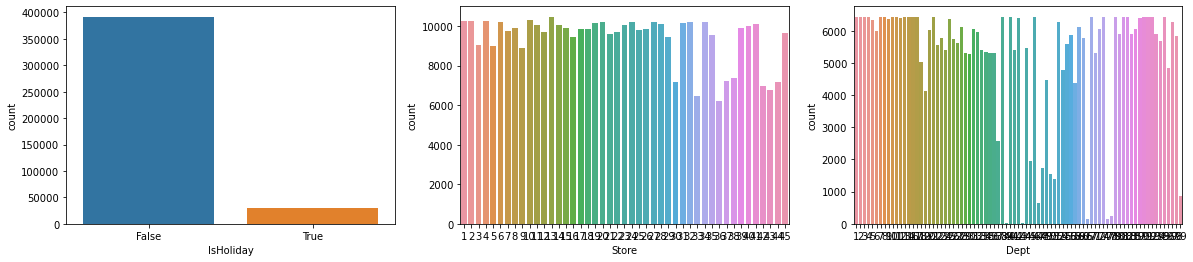

In [6]:
display(df_sales.drop('Weekly_Sales', axis=1).describe().transpose())

fig, axes = plt.subplots(1,3, figsize=(20,4))
sns.countplot(x='IsHoliday', data=df_sales, ax=axes[0])
sns.countplot(x='Store', data=df_sales, ax=axes[1])
sns.countplot(x='Dept', data=df_sales, ax=axes[2])

plt.show()

We can see that:

1. There are 143 unique dates (421,570 records in total) from 2010-02-05 to 2012-10-26 in the `sales` dataframe.
2. There is no missing values in any column of this dataframe, which is good
3. However, we should notice that the `weekly sales` column is extremely right skewed, with a mean of \\$15,981, but a 50th percentile (mostly the same as the median) of only \\$7,612. The range of the column is also fairly wide, from -\\$4,989 to \\$693,099
4. When grouped by stores and departments respectively, it seems that a smaller proportion of departments are affecting the overall skew across stores
5. 391,909 records out of 421,570 are not holidays (or about 7% of the records *are* holidays), which could potentially explain why the `Weekly Sales` records are extremely right skewed (*maybe* most of the sales happen on holidays)
6. 99.68% of the `Weekly_Sales` column is positive, which means that we could potentially drop the negative values without significantly affecting the integraty of our data, so that we would be able to take the logarithms of the rest in order to make our records less skewed
7. There seems to be less records for certain stores and departments than others

#### `Features`

Now let's move onto the `features` dataframe, which has 12 fields (columns) and 8190 observations (rows). Note that, again, we had mannual changed the data types for the 'Store' and 'Date' columns when we imported the data.

In [7]:
print(df_features.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         8190 non-null   category      
 1   Date          8190 non-null   datetime64[ns]
 2   Temperature   8190 non-null   float64       
 3   Fuel_Price    8190 non-null   float64       
 4   MarkDown1     4032 non-null   float64       
 5   MarkDown2     2921 non-null   float64       
 6   MarkDown3     3613 non-null   float64       
 7   MarkDown4     3464 non-null   float64       
 8   MarkDown5     4050 non-null   float64       
 9   CPI           7605 non-null   float64       
 10  Unemployment  7605 non-null   float64       
 11  IsHoliday     8190 non-null   bool          
dtypes: bool(1), category(1), datetime64[ns](1), float64(9)
memory usage: 657.6 KB
None


In [4]:
# inspecting rows containing NaN values
display(df_features[df_features['CPI'].isnull()])
display(df_features[df_features['Unemployment'].isnull()])

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
169,1,2013-05-03,66.66,3.386,2298.63,2.00,129.90,55.46,1301.04,NaN,NaN,False
170,1,2013-05-10,63.90,3.392,4624.61,83.88,42.38,1618.31,8144.90,NaN,NaN,False
171,1,2013-05-17,69.53,3.454,16170.50,92.00,8.32,4127.24,6206.97,NaN,NaN,False
172,1,2013-05-24,77.19,3.494,7959.89,178.00,1621.47,3152.57,2938.70,NaN,NaN,False
173,1,2013-05-31,78.02,3.466,2369.77,142.45,475.35,45.55,2056.84,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...
8185,45,2013-06-28,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,False
8186,45,2013-07-05,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,False
8187,45,2013-07-12,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,False
8188,45,2013-07-19,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,False


,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
169,1,2013-05-03,66.66,3.386,2298.63,2.00,129.90,55.46,1301.04,NaN,NaN,False
170,1,2013-05-10,63.90,3.392,4624.61,83.88,42.38,1618.31,8144.90,NaN,NaN,False
171,1,2013-05-17,69.53,3.454,16170.50,92.00,8.32,4127.24,6206.97,NaN,NaN,False
172,1,2013-05-24,77.19,3.494,7959.89,178.00,1621.47,3152.57,2938.70,NaN,NaN,False
173,1,2013-05-31,78.02,3.466,2369.77,142.45,475.35,45.55,2056.84,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...
8185,45,2013-06-28,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,False
8186,45,2013-07-05,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,False
8187,45,2013-07-12,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,False
8188,45,2013-07-19,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,False


,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
count,8190.00,8190.00,4032.00,2921.00,3613.00,3464.00,4050.00,7605.00,7605.00
mean,59.36,3.41,7032.37,3384.18,1760.10,3292.94,4132.22,172.46,7.83
std,18.68,0.43,9262.75,8793.58,11276.46,6792.33,13086.69,39.74,1.88
min,-7.29,2.47,-2781.45,-265.76,-179.26,0.22,-185.17,126.06,3.68
25%,45.90,3.04,1577.53,68.88,6.60,304.69,1440.83,132.36,6.63
50%,60.71,3.51,4743.58,364.57,36.26,1176.42,2727.14,182.76,7.81
75%,73.88,3.74,8923.31,2153.35,163.15,3310.01,4832.56,213.93,8.57
max,101.95,4.47,103184.98,104519.54,149483.31,67474.85,771448.10,228.98,14.31


CAUTION: 0.10% of MarkDown1 (non-null) is negative.
CAUTION: 0.86% of MarkDown2 (non-null) is negative.
CAUTION: 0.36% of MarkDown3 (non-null) is negative.
CAUTION: 0.00% of MarkDown4 (non-null) is negative.
CAUTION: 0.05% of MarkDown5 (non-null) is negative.


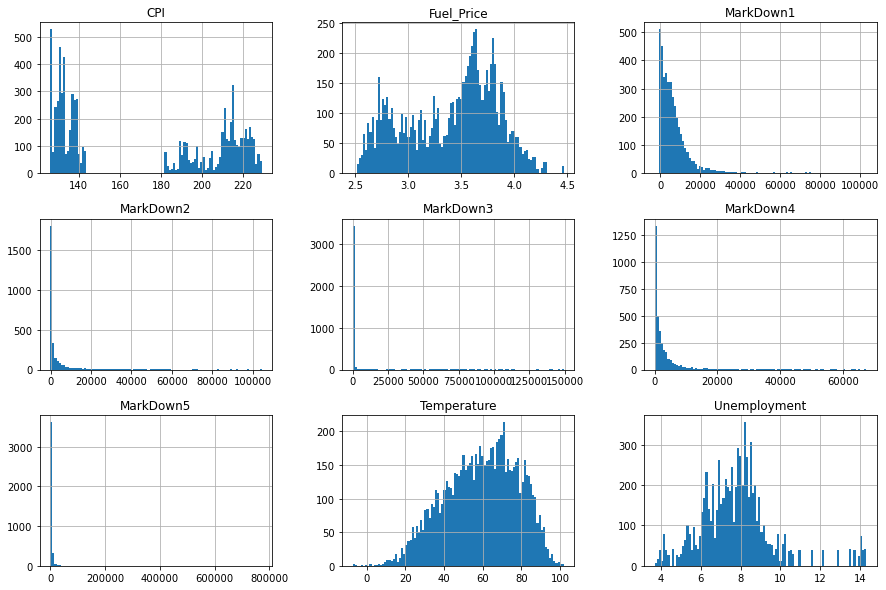

In [9]:
display(df_features.describe().round(2))

for i in range(5):
    print('CAUTION: {:.2%} of MarkDown{} (non-null) is negative.'
          .format(len([n for n in df_features['MarkDown'+str(i+1)] if n < 0])/
                  len(df_features['MarkDown'+str(i+1)].dropna()), i+1))

df_features.drop(['Store', 'Date', 'IsHoliday'], axis=1).hist(figsize=(15,10), bins=100)

plt.show()

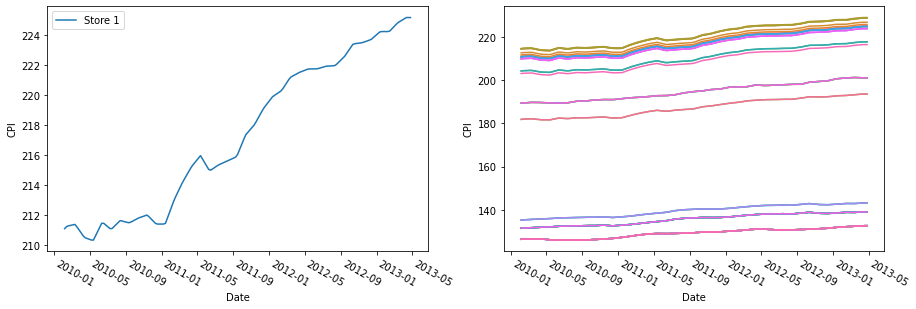

In [5]:
fig, axes = plt.subplots(1,2,figsize=(15,5))

sns.lineplot(x='Date', y='CPI', data=df_features[df_features.Store==1], ax=axes[0], label='Store 1')
sns.lineplot(x="Date", y="CPI", hue="Store", data=df_features, legend=False, ax=axes[1])
fig.autofmt_xdate(rotation=-30, ha='left')

plt.show()

,count,unique,top,freq,first,last
Store,8190,45,45,182,NaT,NaT
Date,8190,182,2011-07-15 00:00:00,45,2010-02-05,2013-07-26
IsHoliday,8190,2,False,7605,NaT,NaT


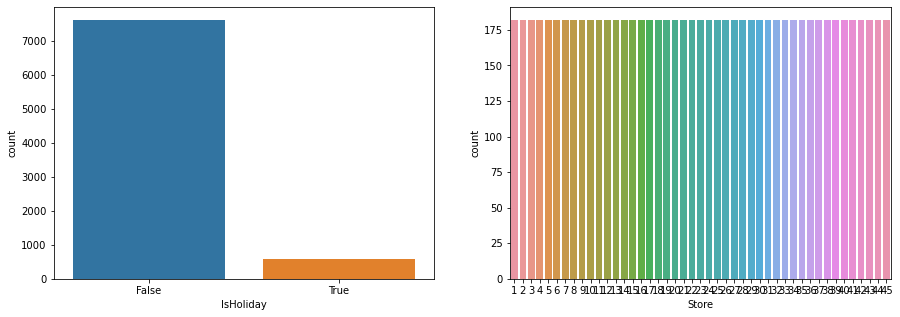

In [11]:
display(df_features[['Store', 'Date', 'IsHoliday']].describe().transpose())

fig, axes = plt.subplots(1,2, figsize=(15,5))
sns.countplot(x='IsHoliday', data=df_features, ax=axes[0])
sns.countplot(x='Store', data=df_features, ax=axes[1])

plt.show()

We can see from the above tables and plots that:

1. Compared to the `sales` dataframe, there are less records (8190) in the `features` dataframe. It makes sense because this dataframe is only detailed to store level and not department (different departments in the same store *probably* experience the same weather on the same day)
2. The are 182 unique dates from 2010-02-05 to 2013-07-26, which is a wider range of record than the `sales` dataframe.
3. The missing values in the 'CPI' and 'Unemployment' columns do not have corresponding observations in the `sales` dataframe (outside of date range), which means that removing these rows would most likely not affect the integrity of our analysis
4. From the first 10 rows, we can see that the dates do match up; however, it wouldn't hurt to check the proportion of matching records (by date and store) especially if we are thinking about merging together the two dataframes
5. The 5 mark down columns contain 'anonymous data related to promotional mark downs' as per Kaggle, and we might want to further inspect these columns (e.g. whether two or more mark downs occured at any point for the same store); at the same time, these 5 columns are also extremely right skewed
6. Less than 1% of each of the markdowns contains negative values, and we could consider dropping these observations if we need to take the logarithms of this field to make it less right skewed
7. CPI (Consumer Price Index) is steadily increasing for all stores, but different stores have different levels of CPIs. There also seems to be a bimodal distribution amongst all the CPI observations
8. Approximately 7% of the 8190 `features` records are holidays, which is consistent with the `sales` dataframe

#### `Stores`

Last but not least, let's take a look at the `stores` dataframe, which only has 3 fields (columns) and 45 observations (rows). Again, note that we had mannually changed the data types for the 'Store' and 'Type' columns when we imported the data.

In [12]:
display(df_stores.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   Store   45 non-null     category
 1   Type    45 non-null     category
 2   Size    45 non-null     int64   
dtypes: category(2), int64(1)
memory usage: 2.3 KB


None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Type,45,3,A,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Size,45,NaN,NaN,NaN,130288,63825.3,34875,70713,126512,202307,219622


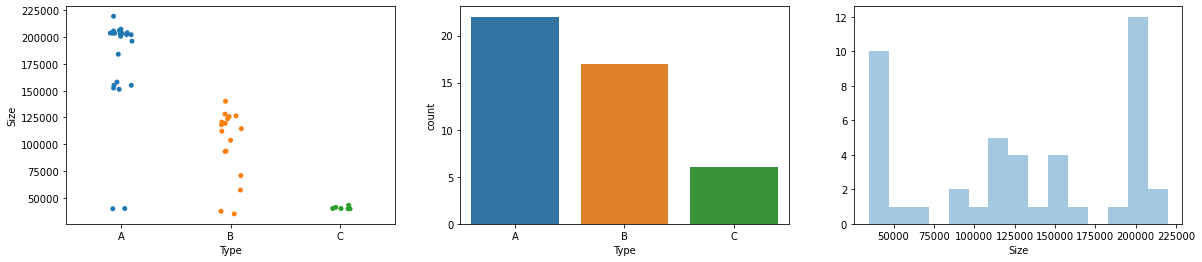

In [13]:
display(pd.DataFrame(df_stores.drop('Store', axis=1).describe(include='all')).transpose().round(2))

fig, axes = plt.subplots(1,3, figsize=(20,4))
sns.stripplot(x='Type', y='Size', data=df_stores, ax=axes[0])
sns.countplot(x='Type', data=df_stores, ax=axes[1])
sns.distplot(df_stores['Size'], bins=15, kde=False, ax=axes[2])

plt.show()

The `stores` dataframe appear to be smaller and simper. We can see that:

1. Almost half of the stores are type A stores; and there is a correlation between store size and store type, with A being the largest and C being the smallest on average
2. `Sizes` of the stores are not extremely skewed, with its mean close to its 50th percentile. However, the sizes of the stores seem to belong to a trimodel distribution, with the left and right peaks being higher (less spreaded out) than the middle one

### Aggregation

After exploring each dataset by itself, it is also a good idea to merge the different datasets so that you could visualize any possible relationships that might exist between two or more variables. In our case, we are going to left join the `features` and `stores` dataframe to the `sales` dataframe, because we want to preserve all the sales data (since we are analyzing sales).

In [46]:
df_merge = df_sales.merge(df_features, on=['Date', 'Store'], how='left').merge(df_stores, on='Store', how='left')

df_merge.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315


Scatter plots are helpful for visualizations of any linear or non-linear relationships between two variables. In our case, we suspect that CPI, Store Size, Unemployment Rate, and Store Type could have potential impacts on sales (besides time). After plotting each of them against Weekly Sales below, we can see that:

1. There seems to be a *slightly* negative relationship betweeen CPI and Sales
2. There also seems to be a *slightly* positive relationship between Size and Sales
3. Unemployment, on the other hand, does not seem to affect sales much
4. Type A stores seem to have the highest sales, whereas Type C stores seem to have the lowest.

Some of this information might provide little to no help in the end; some of them might be repetitive, for example, Store Type, Size, and Sales seem to be correlated to one another. However, it is important to keep these potential relationships in mind when we move on to build our models.

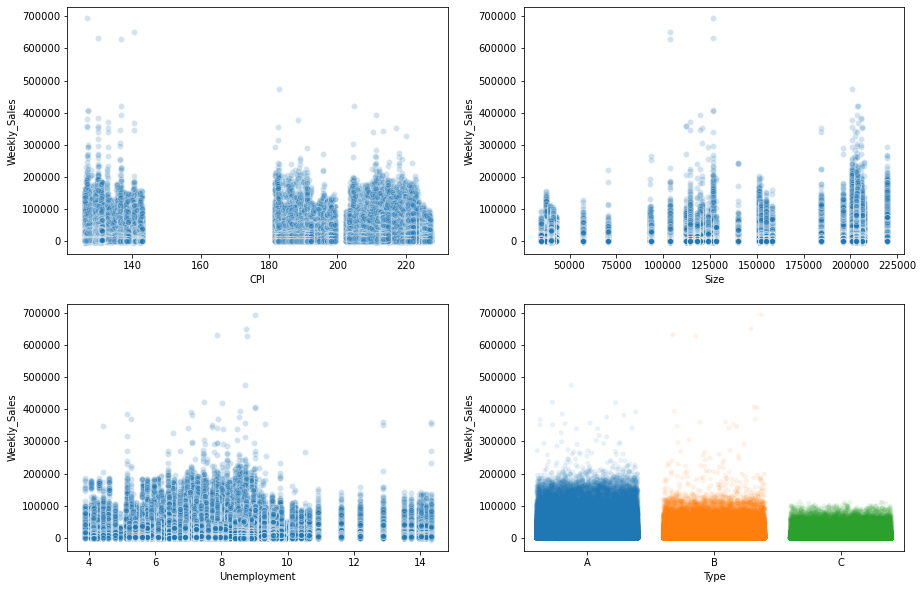

In [45]:
fig, axes = plt.subplots(2, 2, figsize=(15,10))

sns.scatterplot(x='CPI', y='Weekly_Sales', alpha=0.2, data=df_merge, ax=axes[0,0])
sns.scatterplot(x='Size', y='Weekly_Sales', alpha=0.2, data=df_merge, ax=axes[0,1])
sns.scatterplot(x='Unemployment', y='Weekly_Sales', alpha=0.2, data=df_merge, ax=axes[1,0])
sns.stripplot(x='Type', y='Weekly_Sales', jitter=0.4, alpha=0.1, data=df_merge, ax=axes[1,1])

plt.show()

At the beginning of this notebook, we saw that (by randomly inspecting different combinations) seasonalities and trends vary across stores and departments. Some stores/deparments have consistant sales throughout time, while some others see huge spikes either in the middle or at the end of each year. There are also increasing or decreasing trends in certain stores/departments. 

Even though it is nice to be able to see detailed sales performance for each individual department in every store, we also want to inspect whether there are shared patterns in our sales data. Therefore, let's aggregate the data so that we could visualize and compare sales across different stores for the same department and then across different departments in the same store. From the two visualizations below, we can see that when we aggregate by department, the data looks a lot cleaner and organized than when we aggregate by stores. This again, echoes with our previous finding that certain departments are significantly skewing the sales for the entire store.

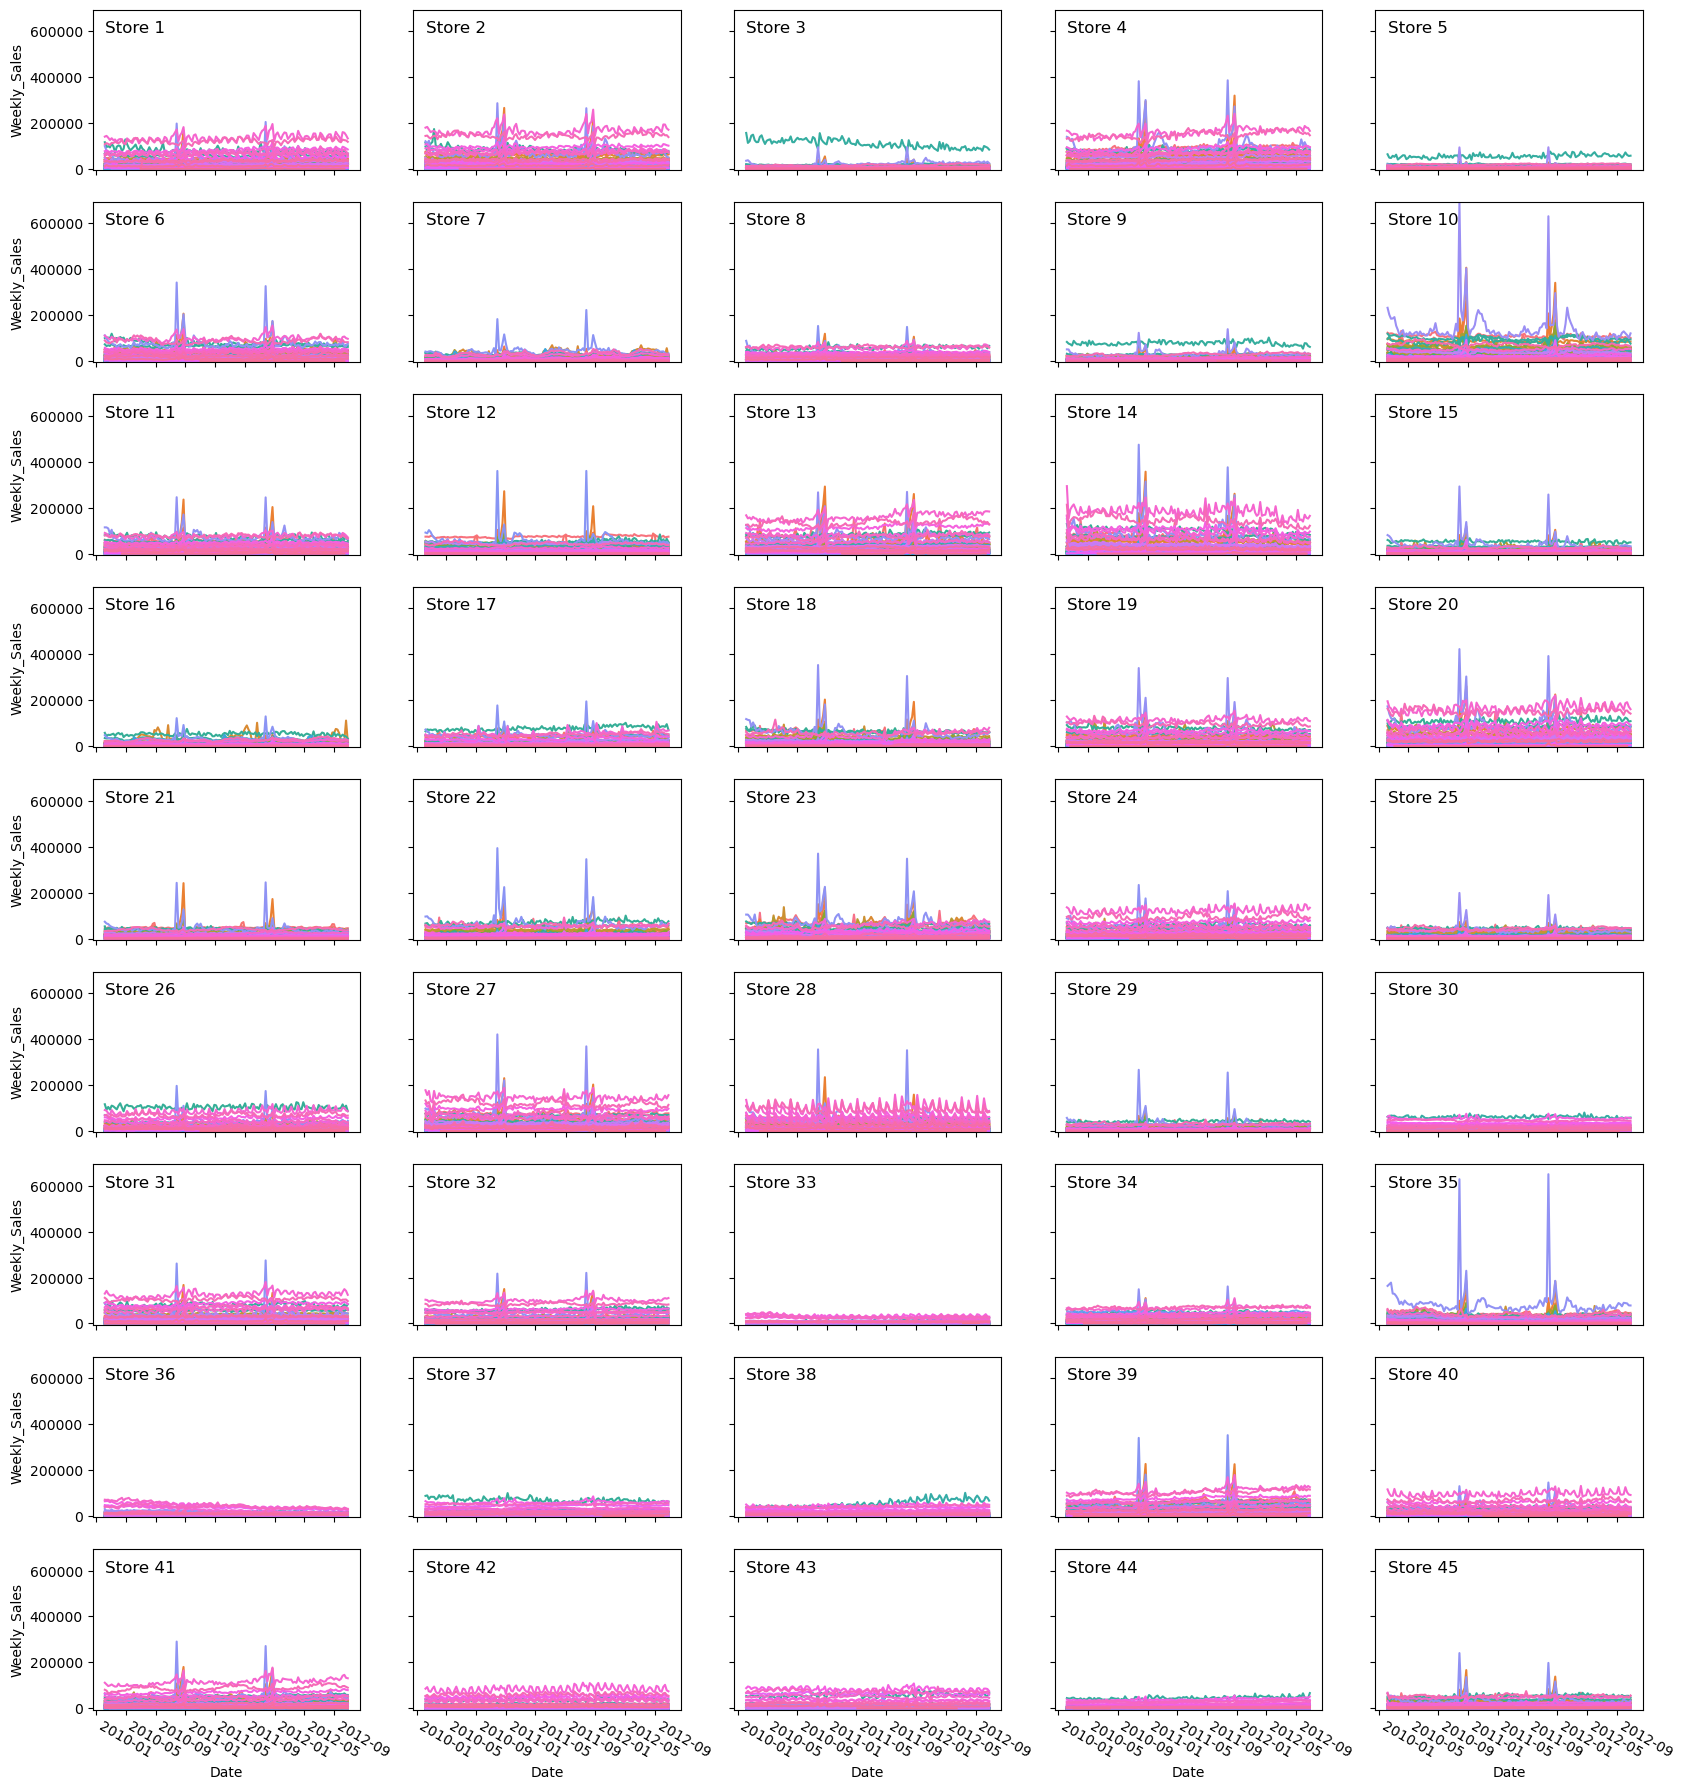

In [8]:
fig, ax = plt.subplots(9, 5, sharex='col', sharey='row', figsize=(20, 25), dpi=100)
plt.setp(ax, ylim=(min(df_sales['Weekly_Sales']), max(df_sales['Weekly_Sales'])))
fig.autofmt_xdate(rotation=-30, ha='left')

store_num = pd.Series(range(1,46), dtype='category')
store_index = 0
for i in range(9):
    for j in range(5):
        sales_temp = df_sales[df_sales.Store==store_num[store_index]][['Date', 'Dept', 'Weekly_Sales']]
        sales_temp['Dept'] = sales_temp['Dept'].astype('category')
        sns.lineplot(x='Date', y='Weekly_Sales', hue='Dept', data=sales_temp, legend=False, ax=ax[i,j])
        ax[i,j].text(min(sales_temp['Date']), max(df_sales['Weekly_Sales'])-100000, 
                     'Store {}'.format(store_index+1), fontsize=12)
        store_index += 1
        
plt.show()

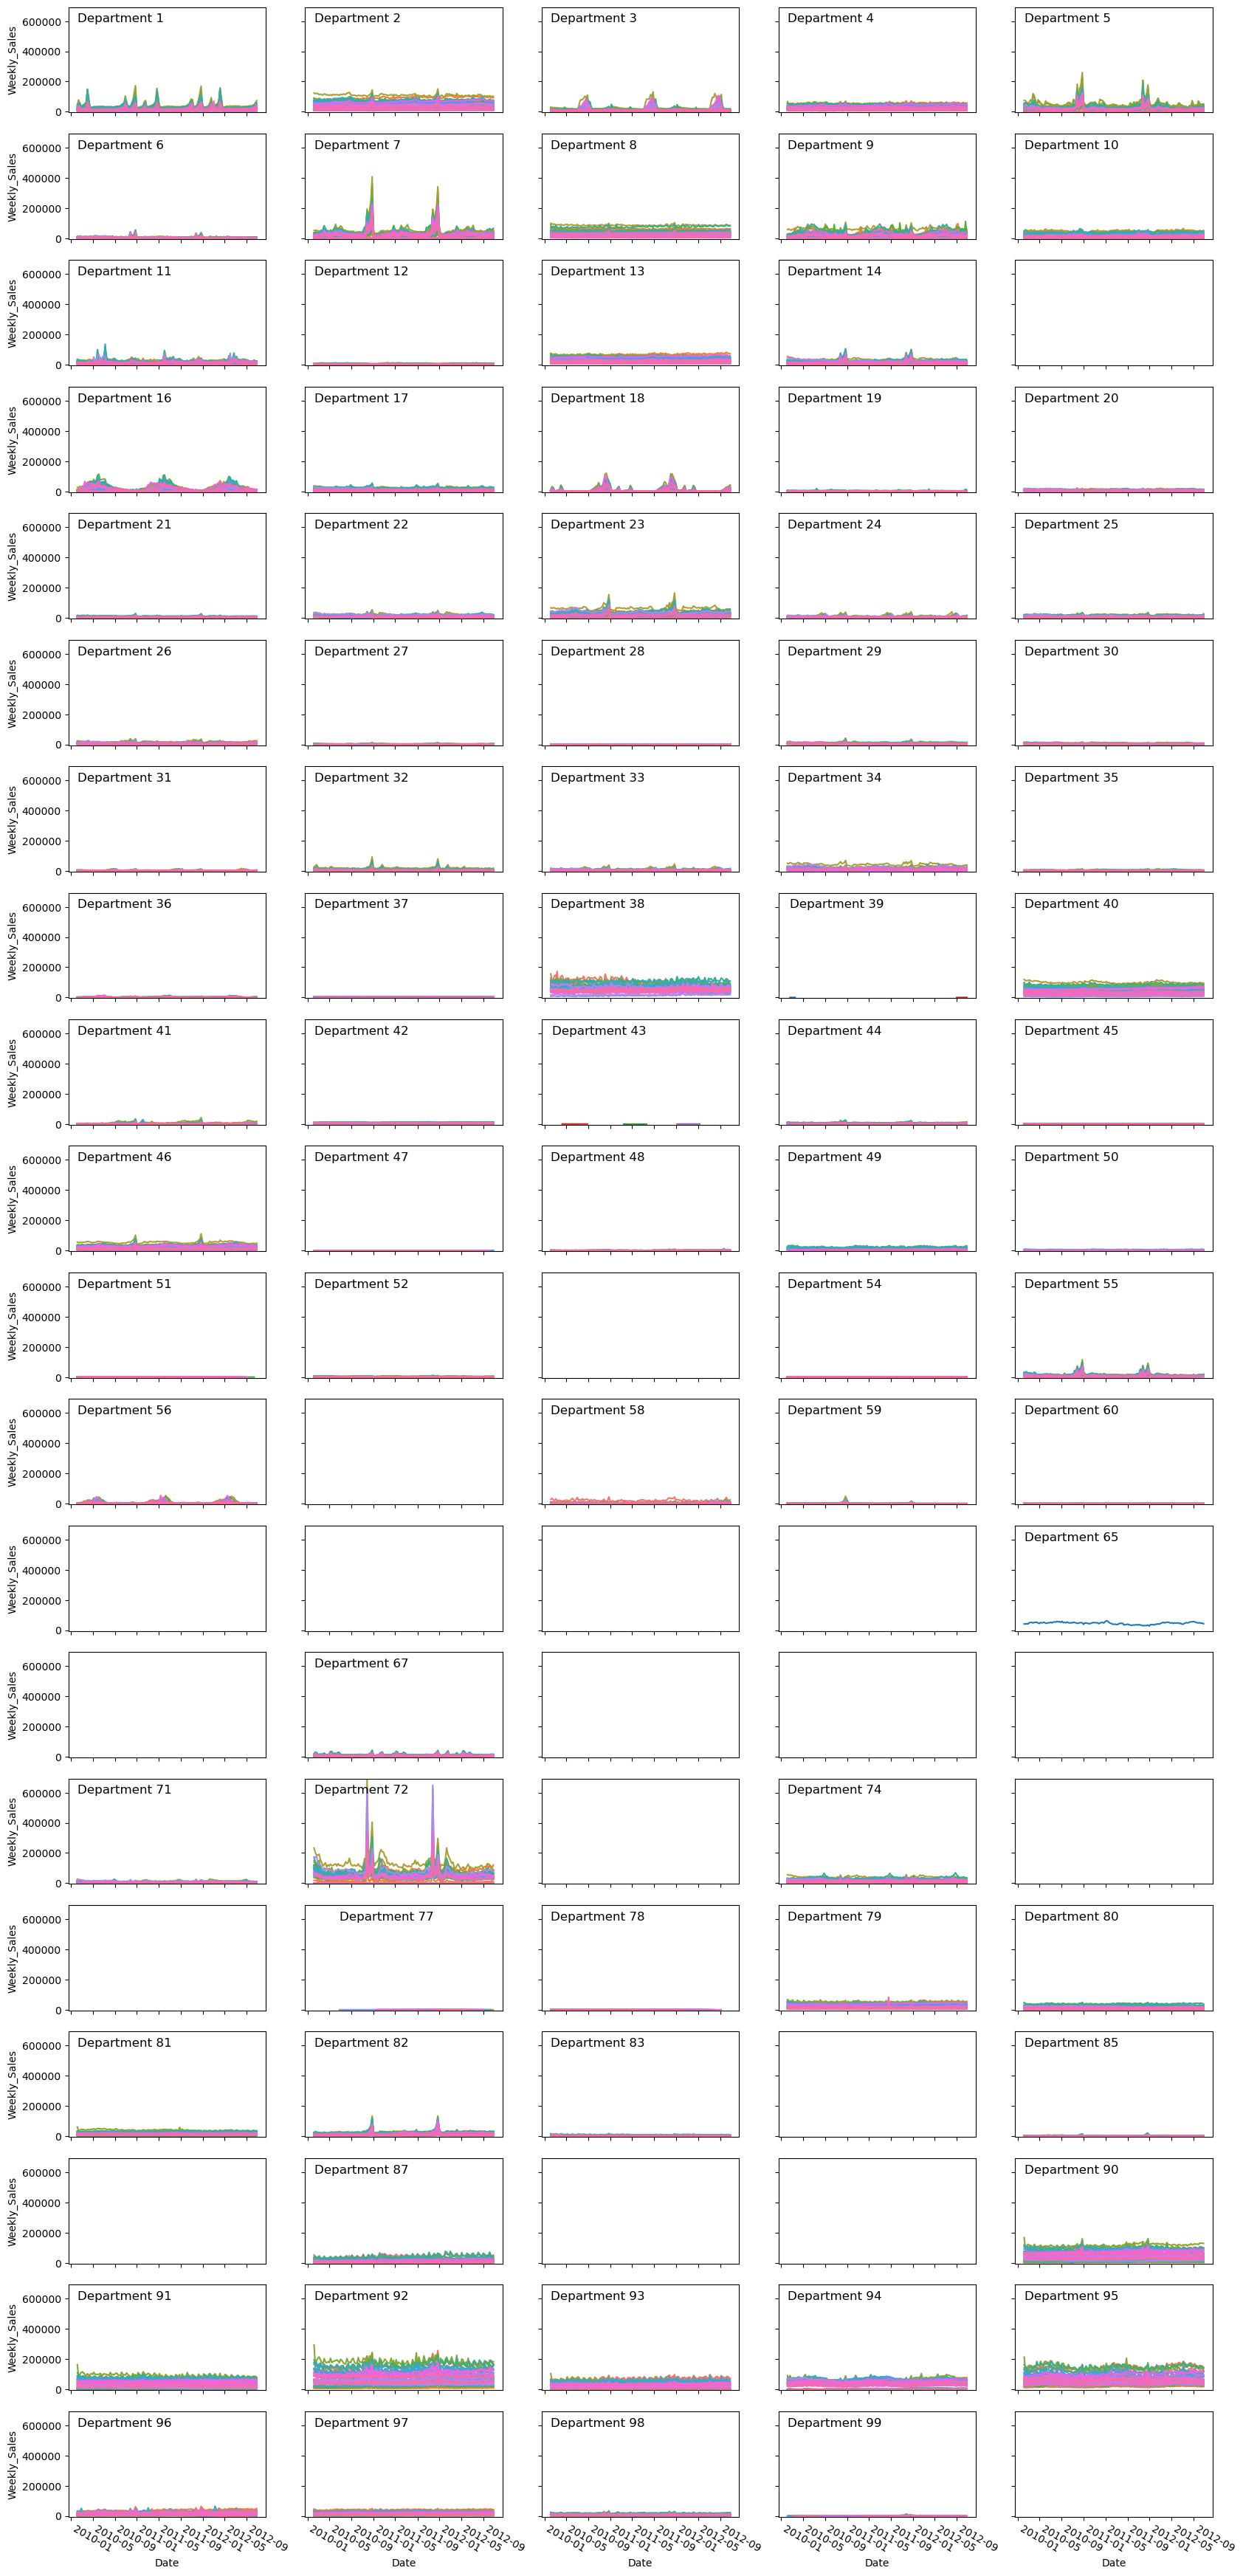

In [12]:
fig, ax = plt.subplots(20, 5, sharex='col', sharey='row', figsize=(20, 50), dpi=100)
plt.setp(ax, ylim=(min(df_sales['Weekly_Sales']), max(df_sales['Weekly_Sales'])))
fig.autofmt_xdate(rotation=-30, ha='left')

dept_num = pd.Series(range(1,101), dtype='category')
dept_index = 0
for i in range(20):
    for j in range(5):
        try: 
            sales_temp = df_sales[df_sales.Dept==dept_num[dept_index]][['Date', 'Store', 'Weekly_Sales']]
            sales_temp['Store'] = sales_temp['Store'].astype('category')
            sns.lineplot(x='Date', y='Weekly_Sales', hue='Store', data=sales_temp, legend=False, ax=ax[i,j])
            ax[i,j].text(min(sales_temp['Date']), max(df_sales['Weekly_Sales'])-100000,
                         'Department {}'.format(dept_index+1), fontsize=12)
            dept_index += 1
        except:
            dept_index += 1
plt.show()